In [65]:
# EPOCH TRACKING FUNCTIONSimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import os
warnings.filterwarnings('ignore')

In [70]:
# Configuration
DATA_PATH = "/content"
N_BUILDINGS_TO_PREDICT = 10
TRAINING_SAMPLES = 300
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
BBOX = {
    'north': 31.250000,
    'south': 31.230000,
    'west': 121.490000,
    'east': 121.520000
}

In [71]:
# Global tracking variables
optimization_history = []
epoch_data = []
current_epoch = 0
print("Animation-enabled MLP optimization starting...")


Animation-enabled MLP optimization starting...


In [72]:
# Load data
def load_data(data_path):
    buildings = pd.read_excel(f"{data_path}/building_height.xlsx")
    green = pd.read_excel(f"{data_path}/green.xlsx")
    heat = pd.read_excel(f"{data_path}/heat_degree.xlsx")
    water = pd.read_excel(f"{data_path}/water.xlsx")
    roads = pd.read_excel(f"{data_path}/road.xlsx")
    return buildings, green, heat, water, roads

buildings_df, green_df, heat_df, water_df, roads_df = load_data(DATA_PATH)

In [73]:
# Optimized feature functions
def calculate_distance_vectorized(x1, y1, x2_array, y2_array):
    return np.sqrt((x1 - x2_array)**2 + (y1 - y2_array)**2)

def get_nearest_distance_fast(x, y, df, x_col='longitude', y_col='latitude'):
    if len(df) == 0:
        return 999
    distances = calculate_distance_vectorized(x, y, df[x_col].values, df[y_col].values)
    return np.min(distances)

def get_nearest_road_distance_fast(x, y, roads_df):
    if len(roads_df) == 0:
        return 999
    distances = calculate_distance_vectorized(x, y, roads_df['longitude'].values, roads_df['latitude'].values)
    return np.min(distances) * 111000

def is_on_green_area_fast(x, y, green_df, tolerance=50):
    if len(green_df) == 0:
        return False
    distances = calculate_distance_vectorized(x, y, green_df['longitude'].values, green_df['latitude'].values)
    return np.any(distances * 111000 <= tolerance)

def create_feature_matrix_single(x, y, buildings_df, green_df, heat_df, water_df, roads_df):
    """Create feature matrix for a single point (faster for individual calculations)"""
    center_x = (BBOX['west'] + BBOX['east']) / 2
    center_y = (BBOX['south'] + BBOX['north']) / 2

    features = [
        x, y,  # longitude, latitude
        get_nearest_distance_fast(x, y, green_df),  # dist_to_green
        get_nearest_distance_fast(x, y, water_df),  # dist_to_water
        get_nearest_distance_fast(x, y, buildings_df),  # dist_to_building
        get_nearest_road_distance_fast(x, y, roads_df),  # dist_to_road
        0, 0, 0, 0,  # densities (simplified for speed)
        25,  # avg_temperature (simplified)
        np.sqrt((x - center_x)**2 + (y - center_y)**2),  # dist_to_center
        1 if is_on_green_area_fast(x, y, green_df) else 0  # on_green_area
    ]

    return np.array(features)

def calculate_energy_score_fast(features, existing_buildings=None):
    """Fast energy calculation - ENHANCED ROAD DISTANCE OBJECTIVE"""
    longitude, latitude = features[0], features[1]
    dist_to_green, dist_to_water, dist_to_road = features[2], features[3], features[5]
    avg_temperature, dist_to_center = features[10], features[11]
    on_green_area = features[12]

    # Start with base optimization score
    optimization_score = 10000  # Base score

    # ENHANCED Road distance constraints (key objective)
    if dist_to_road < 20:  # Too close to roads (safety/noise concern)
        penalty = (20 - dist_to_road) * 1000  # Heavy penalty for being too close
        optimization_score -= penalty
    elif dist_to_road >= 20 and dist_to_road <= 150:  # Optimal zone
        bonus = 1500 - abs(dist_to_road - 85) * 10  # Best around 85m from road
        optimization_score += bonus
    elif dist_to_road > 150 and dist_to_road <= 300:  # Acceptable but not ideal
        penalty = (dist_to_road - 150) * 5  # Moderate penalty for being far
        optimization_score -= penalty
    else:  # Too far from roads (>300m) - accessibility issues
        penalty = (dist_to_road - 300) * 15  # Increasing penalty for very remote locations
        optimization_score -= penalty

    # Green area logic (environmental objective)
    if on_green_area:
        optimization_score += 2000  # Big bonus for being on green area
    else:
        green_penalty = min(dist_to_green * 100, 1000)  # Cap penalty at 1000
        optimization_score -= green_penalty

    # Water proximity bonus (view quality)
    if dist_to_water <= 200:  # Close to water
        water_bonus = (200 - dist_to_water) * 5
        optimization_score += water_bonus

    # Temperature optimization (comfort objective)
    temp_penalty = abs(avg_temperature - 25) * 30
    optimization_score -= temp_penalty

    # Distance to center (accessibility objective)
    center_penalty = dist_to_center * 200
    optimization_score -= center_penalty

    # Building spacing (urban planning objective)
    if existing_buildings is not None and len(existing_buildings) > 0:
        for existing in existing_buildings:
            distance = np.sqrt((longitude - existing[0])**2 + (latitude - existing[1])**2) * 111000  # Convert to meters
            if distance < 250:  # Minimum spacing requirement
                spacing_penalty = (250 - distance) * 50  # Heavy penalty for crowding
                optimization_score -= spacing_penalty
            elif distance >= 250 and distance <= 500:  # Good spacing
                spacing_bonus = (distance - 250) * 2  # Small bonus for good spacing
                optimization_score += min(spacing_bonus, 500)  # Cap bonus

    # Ensure score is always positive
    return max(optimization_score, 100)

In [74]:
# BUILDING ORIENTATION CALCULATION
def calculate_optimal_orientation(longitude, latitude, water_df, green_df):
    """Calculate optimal building orientation based on water/green views"""

    # Find nearest water body
    if len(water_df) > 0:
        water_distances = calculate_distance_vectorized(longitude, latitude,
                                                       water_df['longitude'].values,
                                                       water_df['latitude'].values)
        nearest_water_idx = np.argmin(water_distances)
        nearest_water = water_df.iloc[nearest_water_idx]

        # Calculate angle to water
        dx_water = nearest_water['longitude'] - longitude
        dy_water = nearest_water['latitude'] - latitude
        angle_to_water = np.degrees(np.arctan2(dy_water, dx_water))

        # If water is close enough (< 500m), orient toward water
        if water_distances[nearest_water_idx] * 111000 < 500:
            return angle_to_water, "water", water_distances[nearest_water_idx] * 111000

    # Otherwise, find nearest green area
    if len(green_df) > 0:
        green_distances = calculate_distance_vectorized(longitude, latitude,
                                                       green_df['longitude'].values,
                                                       green_df['latitude'].values)
        nearest_green_idx = np.argmin(green_distances)
        nearest_green = green_df.iloc[nearest_green_idx]

        # Calculate angle to green area
        dx_green = nearest_green['longitude'] - longitude
        dy_green = nearest_green['latitude'] - latitude
        angle_to_green = np.degrees(np.arctan2(dy_green, dx_green))

        return angle_to_green, "green", green_distances[nearest_green_idx] * 111000

    # Default orientation (facing east)
    return 90, "default", 999
def save_epoch_data(epoch, buildings, energy_scores, best_energy):
    """Save data for each epoch"""
    epoch_info = {
        'epoch': epoch,
        'buildings': buildings.copy(),
        'energy_scores': energy_scores.copy(),
        'best_energy': best_energy,
        'n_buildings': len(buildings)
    }
    epoch_data.append(epoch_info)

def save_optimization_history():
    """Save complete optimization history to Excel"""
    history_file = f"{DATA_PATH}/optimization_history.xlsx"

    # Create detailed history DataFrame
    history_records = []
    for epoch_info in epoch_data:
        for i, building in enumerate(epoch_info['buildings']):
            history_records.append({
                'Epoch': epoch_info['epoch'],
                'Building_ID': building.get('id', i + 1),
                'Longitude': building['longitude'],
                'Latitude': building['latitude'],
                'Area_sqm': building.get('area', 0),
                'Width_m': building.get('width', 0),
                'Length_m': building.get('length', 0),
                'Height_m': building.get('height', 0),
                'Aspect_Ratio': building.get('aspect_ratio', '2:3'),
                'Orientation_Angle': building.get('orientation_angle', 0),
                'View_Type': building.get('view_type', 'unknown'),
                'View_Distance_m': building.get('view_distance', 0),
                'Energy_Score': building.get('energy_score', 0),
                'Road_Distance_m': building.get('road_distance', 0),
                'Water_Distance_m': building.get('water_distance', 0),
                'Green_Distance_m': building.get('green_distance', 0),
                'On_Green_Area': building.get('on_green_area', False),
                'Best_Energy_This_Epoch': epoch_info['best_energy']
            })

    history_df = pd.DataFrame(history_records)
    history_df.to_excel(history_file, index=False)
    print(f"✓ Optimization history saved: {history_file}")
    return history_df

In [75]:
# BUILDING RESULTS EXPORT
def save_building_results():
    """Save final building results in the requested format"""
    if len(epoch_data) == 0:
        print("⚠ No optimization data available!")
        return None

    # Get final buildings
    final_buildings = epoch_data[-1]['buildings']

    # Create building results DataFrame
    building_results = []
    for building in final_buildings:
        building_results.append({
            'Building_ID': building.get('id', 0),
            'Longitude': round(building['longitude'], 6),
            'Latitude': round(building['latitude'], 6),
            'Area_sqm': round(building.get('area', 0), 2),
            'Width_m': round(building.get('width', 0), 2),
            'Length_m': round(building.get('length', 0), 2),
            'Height_m': round(building.get('height', 0), 2),
            'Aspect_Ratio': building.get('aspect_ratio', '2:3'),
            'Orientation_Angle_deg': round(building.get('orientation_angle', 0), 1),
            'View_Type': building.get('view_type', 'unknown'),
            'View_Distance_m': round(building.get('view_distance', 0), 1),
            'Final_Score': round(building.get('energy_score', 0), 1),
            'Road_Distance_m': round(building.get('road_distance', 0), 1),
            'Water_Distance_m': round(building.get('water_distance', 0), 1),
            'Green_Distance_m': round(building.get('green_distance', 0), 1),
            'On_Green_Area': building.get('on_green_area', False),
            'Optimization_Status': 'Completed'
        })

    results_df = pd.DataFrame(building_results)

    # Save to Excel
    results_file = f"{DATA_PATH}/MLP_Building_Results.xlsx"
    results_df.to_excel(results_file, index=False)
    print(f"✓ Building results saved: {results_file}")

    return results_df

In [76]:
# ANIMATION GENERATION FUNCTIONS
def create_energy_heatmap(buildings, grid_size=40):  # Reduced grid size for speed
    """Create energy heatmap for current building configuration - DYNAMIC VERSION"""
    # Create grid
    x_grid = np.linspace(BBOX['west'], BBOX['east'], grid_size)
    y_grid = np.linspace(BBOX['south'], BBOX['north'], grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

    # Calculate energy for each grid point
    energy_map = np.zeros((grid_size, grid_size))

    # IMPORTANT: Include existing buildings in the calculation
    # This creates a dynamic heatmap that changes as buildings are placed
    existing_coords = [[b['longitude'], b['latitude']] for b in buildings] if buildings else None

    for i in range(grid_size):
        for j in range(grid_size):
            x, y = X_grid[i, j], Y_grid[i, j]

            # Create a temporary buildings_df that includes both existing buildings AND our optimized buildings
            temp_buildings_df = buildings_df.copy()

            if buildings:
                # Add current optimized buildings to the buildings dataframe for distance calculations
                for building in buildings:
                    new_row = pd.DataFrame({
                        'longitude': [building['longitude']],
                        'latitude': [building['latitude']]
                    })
                    temp_buildings_df = pd.concat([temp_buildings_df, new_row], ignore_index=True)

            # Calculate features using the updated buildings dataframe
            features = create_feature_matrix_single(x, y, temp_buildings_df, green_df, heat_df, water_df, roads_df)

            # Calculate energy score considering all existing buildings (including our optimized ones)
            optimization_score = calculate_energy_score_fast(features, existing_coords)

            # Invert for heatmap display (lower values = better for visualization)
            energy_map[i, j] = 15000 - optimization_score  # Invert so red = bad, green = good

    return X_grid, Y_grid, energy_map

In [77]:
# MODIFIED OPTIMIZATION WITH ITERATIVE POSITION REFINEMENT
def generate_optimal_locations_with_iterative_tracking(n_buildings=10, max_epochs=200):
    """Generate optimal locations using iterative position refinement"""
    global current_epoch, epoch_data, optimization_history

    # Clear previous data
    epoch_data = []
    optimization_history = []
    current_epoch = 0

    print(f"Starting iterative optimization for {n_buildings} buildings over {max_epochs} epochs...")

    # STEP 1: Initialize all buildings at random positions
    print(f"Epoch {current_epoch}: Initializing {n_buildings} buildings at random positions...")
    buildings = []

    for building_id in range(n_buildings):
        # Generate random valid initial position
        attempts = 0
        while attempts < 200:  # Increased attempts for better initial placement
            x_init = np.random.uniform(BBOX['west'], BBOX['east'])
            y_init = np.random.uniform(BBOX['south'], BBOX['north'])

            # Check road constraint - Updated minimum distance
            features = create_feature_matrix_single(x_init, y_init, buildings_df, green_df, heat_df, water_df, roads_df)
            if features[5] >= 20:  # Road distance constraint (minimum 20m from roads)
                # Check building spacing
                valid = True
                for existing in buildings:
                    dist = np.sqrt((x_init - existing['longitude'])**2 + (y_init - existing['latitude'])**2) * 111000
                    if dist < 250:  # 250m minimum spacing
                        valid = False
                        break

                if valid:
                    # Calculate initial optimization score
                    existing_coords = [[b['longitude'], b['latitude']] for b in buildings]
                    optimization_score = calculate_energy_score_fast(features, existing_coords)

                    # Calculate building orientation and dimensions
                    orientation, view_type, view_distance = calculate_optimal_orientation(
                        x_init, y_init, water_df, green_df)

                    # Building dimensions (2:3 ratio)
                    base_area = 500 + np.random.normal(0, 100)
                    width = np.sqrt(base_area * 2/3)  # Shorter side
                    length = np.sqrt(base_area * 3/2)  # Longer side (faces view)

                    building = {
                        'id': building_id + 1,
                        'longitude': x_init,
                        'latitude': y_init,
                        'road_distance': features[5],
                        'water_distance': features[3],
                        'green_distance': features[2],
                        'on_green_area': bool(features[12]),
                        'energy_score': optimization_score,
                        'area': base_area,
                        'width': width,
                        'length': length,
                        'height': 20 + np.random.normal(0, 5),
                        'orientation_angle': orientation,
                        'view_type': view_type,
                        'view_distance': view_distance,
                        'aspect_ratio': '2:3'
                    }
                    buildings.append(building)
                    break
            attempts += 1

        if len(buildings) <= building_id:
            print(f"⚠ Warning: Could not place building {building_id + 1} after {attempts} attempts")

    print(f"✓ Initialized {len(buildings)} buildings")

    # Calculate total optimization score for initial configuration
    total_score = sum(b['energy_score'] for b in buildings)
    save_epoch_data(current_epoch, buildings, [b['energy_score'] for b in buildings], total_score)
    current_epoch += 1

    # STEP 2: Iterative position refinement
    for epoch in range(1, max_epochs + 1):
        print(f"Epoch {epoch}: Refining building positions...")

        improved_buildings = []
        epoch_energies = []
        improvements_made = 0

        # For each building, try to find a better position
        for i, building in enumerate(buildings):
            current_pos = (building['longitude'], building['latitude'])
            current_score = building['energy_score']

            best_pos = current_pos
            best_score = current_score
            best_features = None

            # Generate candidate positions around current location
            search_radius = max(0.002 * (1 - epoch/max_epochs), 0.0002)  # Adaptive search radius
            n_candidates = 100  # Increased for better search

            for _ in range(n_candidates):
                # Generate candidate position (local search around current position)
                if epoch < 20:  # Early epochs: larger search radius
                    angle = np.random.uniform(0, 2*np.pi)
                    radius = np.random.uniform(0, search_radius)
                    x_candidate = current_pos[0] + radius * np.cos(angle)
                    y_candidate = current_pos[1] + radius * np.sin(angle)
                else:  # Later epochs: smaller refinements
                    x_candidate = current_pos[0] + np.random.normal(0, search_radius/3)
                    y_candidate = current_pos[1] + np.random.normal(0, search_radius/3)

                # Keep within bounds
                x_candidate = np.clip(x_candidate, BBOX['west'], BBOX['east'])
                y_candidate = np.clip(y_candidate, BBOX['south'], BBOX['north'])

                # Check constraints
                valid = True

                # Road constraint - Updated minimum distance
                features = create_feature_matrix_single(x_candidate, y_candidate, buildings_df, green_df, heat_df, water_df, roads_df)
                if features[5] < 20:  # Must be at least 20m from roads
                    continue

                # Building spacing constraint - Updated to 250m minimum
                for j, other_building in enumerate(buildings):
                    if i == j:  # Skip self
                        continue
                    dist = np.sqrt((x_candidate - other_building['longitude'])**2 +
                                 (y_candidate - other_building['latitude'])**2) * 111000
                    if dist < 250:  # 250m minimum spacing between buildings
                        valid = False
                        break

                if not valid:
                    continue

                # Calculate optimization score for this candidate position
                other_coords = [[buildings[j]['longitude'], buildings[j]['latitude']]
                              for j in range(len(buildings)) if j != i]
                score = calculate_energy_score_fast(features, other_coords)

                # Accept if better (maximizing optimization score)
                if score > best_score:
                    best_pos = (x_candidate, y_candidate)
                    best_score = score
                    best_features = features

            # Update building with best position found
            improved_building = building.copy()
            improved_building['longitude'] = best_pos[0]
            improved_building['latitude'] = best_pos[1]
            improved_building['energy_score'] = best_score

            if best_features is not None:
                improved_building['road_distance'] = best_features[5]
                improved_building['water_distance'] = best_features[3]
                improved_building['green_distance'] = best_features[2]
                improved_building['on_green_area'] = bool(best_features[12])

                # Recalculate orientation for new position
                orientation, view_type, view_distance = calculate_optimal_orientation(
                    best_pos[0], best_pos[1], water_df, green_df)
                improved_building['orientation_angle'] = orientation
                improved_building['view_type'] = view_type
                improved_building['view_distance'] = view_distance

            improved_buildings.append(improved_building)
            epoch_energies.append(best_score)

            # Track improvements
            if best_score > current_score:  # Changed to > for maximization
                improvements_made += 1

        # Update buildings list
        buildings = improved_buildings
        total_score = sum(epoch_energies)

        print(f"✓ Epoch {epoch}: {improvements_made}/{len(buildings)} buildings improved, Total Score: {total_score:.1f}")

        # Save epoch data
        save_epoch_data(current_epoch, buildings, epoch_energies, total_score)
        current_epoch += 1

        # Early stopping if no improvements for multiple epochs
        if improvements_made == 0 and epoch > 30:
            print(f"🎯 Convergence reached at epoch {epoch}")
            break

    print(f"✓ Optimization complete! Final total score: {sum(b['energy_score'] for b in buildings):.1f}")
    return buildings

In [78]:
# ENHANCED ANIMATION FUNCTION FOR ITERATIVE TRACKING
def create_iterative_optimization_animation():
    """Create animated visualization of iterative optimization process"""
    print("Creating iterative optimization animation...")

    if len(epoch_data) == 0:
        print("⚠ No epoch data available for animation!")
        return None

    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Custom colormap
    colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('energy', colors, N=n_bins)

    # Store building trajectories for trail visualization
    max_buildings = max(len(epoch['buildings']) for epoch in epoch_data) if epoch_data else N_BUILDINGS_TO_PREDICT
    building_trails = {i+1: {'x': [], 'y': []} for i in range(max_buildings)}

    def animate(frame):
        ax1.clear()
        ax2.clear()

        if frame >= len(epoch_data):
            return

        current_data = epoch_data[frame]
        buildings = current_data['buildings']
        epoch = current_data['epoch']

        # Update building trails
        for building in buildings:
            building_id = building.get('id', len([b for b in buildings if b == building]) + 1)
            if building_id in building_trails:
                building_trails[building_id]['x'].append(building['longitude'])
                building_trails[building_id]['y'].append(building['latitude'])

        # Left plot: Energy heatmap with building positions
        if len(buildings) > 0:
            X_grid, Y_grid, energy_map = create_energy_heatmap(buildings)

            # Normalize energy values for better visualization
            energy_map_norm = (energy_map - np.min(energy_map)) / (np.max(energy_map) - np.min(energy_map))

            im = ax1.contourf(X_grid, Y_grid, energy_map_norm, levels=30, cmap=cmap, alpha=0.8)  # Reduced levels for speed

        # Plot existing infrastructure
        if len(buildings_df) > 0:
            ax1.scatter(buildings_df['longitude'], buildings_df['latitude'],
                       c='gray', s=15, alpha=0.4, label='Existing Buildings')

        if len(roads_df) > 0:
            ax1.scatter(roads_df['longitude'], roads_df['latitude'],
                       c='brown', s=8, alpha=0.3, marker='s', label='Roads')

        if len(green_df) > 0:
            ax1.scatter(green_df['longitude'], green_df['latitude'],
                       c='forestgreen', s=25, alpha=0.6, label='Green Areas')

        if len(water_df) > 0:
            ax1.scatter(water_df['longitude'], water_df['latitude'],
                       c='blue', s=30, alpha=0.7, label='Water Bodies', marker='o')

        # Plot building trajectories (trails) - REMOVED per request
        # No building path trails displayed

        # Plot current buildings with orientation indicators
        if buildings:
            building_lons = [b['longitude'] for b in buildings]
            building_lats = [b['latitude'] for b in buildings]
            building_colors = ['lightgreen' if b.get('on_green_area', False) else 'red' for b in buildings]
            building_ids = [b.get('id', i+1) for i, b in enumerate(buildings)]

            scatter = ax1.scatter(building_lons, building_lats, c=building_colors, s=120,
                       edgecolors='black', linewidth=2, alpha=0.9,
                       label=f'Buildings (n={len(buildings)})')

            # Add building numbers and orientation arrows
            for i, (lon, lat, bid) in enumerate(zip(building_lons, building_lats, building_ids)):
                ax1.annotate(f'{bid}', (lon, lat), xytext=(0, 0),
                           textcoords='offset points', fontsize=10,
                           fontweight='bold', ha='center', va='center', color='white')

                # Add orientation arrow
                if i < len(buildings):
                    building = buildings[i]
                    orientation = building.get('orientation_angle', 0)
                    arrow_length = 0.0005
                    dx = arrow_length * np.cos(np.radians(orientation))
                    dy = arrow_length * np.sin(np.radians(orientation))
                    ax1.arrow(lon, lat, dx, dy, head_width=0.0001, head_length=0.0001,
                             fc='yellow', ec='yellow', alpha=0.8)

        # Plot formatting
        ax1.set_xlim(BBOX['west'], BBOX['east'])
        ax1.set_ylim(BBOX['south'], BBOX['north'])
        ax1.set_title(f'Building Position Optimization - Epoch {epoch}\nIterative Refinement Progress', fontsize=14)
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=9)

        # Right plot: Optimization score evolution and convergence
        if len(epoch_data) > 1:
            epochs = [d['epoch'] for d in epoch_data[:frame+1]]
            optimization_scores = [d['best_energy'] for d in epoch_data[:frame+1]]

            ax2.plot(epochs, optimization_scores, 'b-', linewidth=3, marker='o', markersize=6, label='Total Optimization Score')
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Total Optimization Score', fontsize=12)
            ax2.set_title('Optimization Progress (Higher = Better)', fontsize=14)
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=10)

            # Add improvement annotation
            if len(optimization_scores) > 1:
                improvement = optimization_scores[-1] - optimization_scores[0]
                ax2.text(0.02, 0.98, f'Total Improvement: +{improvement:.1f}',
                        transform=ax2.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()

    # Create animation - Show only 10 epochs
    max_frames = min(len(epoch_data), 11)  # Epoch 0-10 = 11 frames
    anim = animation.FuncAnimation(fig, animate, frames=max_frames,
                                 interval=1000, repeat=True, blit=False)

    # Save animation
    animation_file = f"{DATA_PATH}/iterative_optimization_animation.gif"
    try:
        anim.save(animation_file, writer='pillow', fps=1.5)
        print(f"✓ Iterative animation saved: {animation_file}")
    except Exception as e:
        print(f"⚠ GIF save failed: {e}")

    # Save MP4
    try:
        mp4_file = f"{DATA_PATH}/iterative_optimization_animation.mp4"
        anim.save(mp4_file, writer='ffmpeg', fps=1.5)
        print(f"✓ MP4 animation saved: {mp4_file}")
    except Exception as e:
        print(f"⚠ MP4 save failed (ffmpeg may not be available): {e}")

    plt.show()
    return anim

In [79]:
# FINAL DESTINATION VISUALIZATION
def create_final_destination_plot():
    """Create a static plot showing the final optimized building positions"""
    print("Creating final destination visualization...")

    if len(epoch_data) == 0:
        print("⚠ No optimization data available!")
        return None

    # Get final epoch data
    final_data = epoch_data[-1]
    final_buildings = final_data['buildings']
    final_epoch = final_data['epoch']

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Custom colormap
    colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('energy', colors, N=n_bins)

    # Create final energy heatmap
    if len(final_buildings) > 0:
        X_grid, Y_grid, energy_map = create_energy_heatmap(final_buildings)

        # Normalize energy values for better visualization
        energy_map_norm = (energy_map - np.min(energy_map)) / (np.max(energy_map) - np.min(energy_map))

        im = ax.contourf(X_grid, Y_grid, energy_map_norm, levels=50, cmap=cmap, alpha=0.8)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Energy Landscape (Red=Bad, Green=Good)', fontsize=12)

    # Plot existing infrastructure
    if len(buildings_df) > 0:
        ax.scatter(buildings_df['longitude'], buildings_df['latitude'],
                   c='gray', s=20, alpha=0.6, label='Existing Buildings', marker='s')

    if len(roads_df) > 0:
        ax.scatter(roads_df['longitude'], roads_df['latitude'],
                   c='brown', s=12, alpha=0.5, marker='s', label='Roads')

    if len(green_df) > 0:
        ax.scatter(green_df['longitude'], green_df['latitude'],
                   c='forestgreen', s=40, alpha=0.8, label='Green Areas', marker='^')

    # Plot final optimized buildings
    if final_buildings:
        building_lons = [b['longitude'] for b in final_buildings]
        building_lats = [b['latitude'] for b in final_buildings]
        building_colors = ['lightgreen' if b.get('on_green_area', False) else 'red' for b in final_buildings]
        building_ids = [b.get('id', i+1) for i, b in enumerate(final_buildings)]
        building_scores = [b.get('energy_score', 0) for b in final_buildings]

        # Plot buildings with different sizes based on scores
        scatter = ax.scatter(building_lons, building_lats, c=building_colors, s=150,
                   edgecolors='black', linewidth=3, alpha=0.9,
                   label=f'Optimized Buildings (n={len(final_buildings)})')

        # Add building numbers and orientation details
        for i, (lon, lat, bid, score) in enumerate(zip(building_lons, building_lats, building_ids, building_scores)):
            ax.annotate(f'{bid}', (lon, lat), xytext=(0, 0),
                       textcoords='offset points', fontsize=12,
                       fontweight='bold', ha='center', va='center', color='white')

            # Add orientation arrow and info
            if i < len(final_buildings):
                building = final_buildings[i]
                orientation = building.get('orientation_angle', 0)
                view_type = building.get('view_type', 'unknown')

                # Orientation arrow
                arrow_length = 0.001
                dx = arrow_length * np.cos(np.radians(orientation))
                dy = arrow_length * np.sin(np.radians(orientation))
                ax.arrow(lon, lat, dx, dy, head_width=0.0002, head_length=0.0002,
                        fc='yellow', ec='yellow', alpha=0.9, linewidth=2)

            # Score and view info annotation
            view_info = f'Score: {score:.0f}\nView: {view_type}'
            ax.annotate(view_info, (lon, lat), xytext=(15, -25),
                       textcoords='offset points', fontsize=9,
                       ha='left', va='center',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    # Plot formatting
    ax.set_xlim(BBOX['west'], BBOX['east'])
    ax.set_ylim(BBOX['south'], BBOX['north'])
    ax.set_title(f'Final Optimized Building Positions - Epoch {final_epoch}\n'
                f'Total Score: {final_data["best_energy"]:.1f}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=11)
    ax.grid(True, alpha=0.3)

    # Add summary statistics
    if final_buildings:
        total_score = sum(b['energy_score'] for b in final_buildings)
        avg_score = total_score / len(final_buildings)
        buildings_on_green = sum(1 for b in final_buildings if b.get('on_green_area', False))
        water_view_buildings = sum(1 for b in final_buildings if b.get('view_type') == 'water')
        green_view_buildings = sum(1 for b in final_buildings if b.get('view_type') == 'green')

        summary_text = f"""Final Optimization Results:
• Total Buildings: {len(final_buildings)}
• Total Score: {total_score:.1f}
• Average Score: {avg_score:.1f}
• Buildings on Green: {buildings_on_green}/{len(final_buildings)}
• Water View Buildings: {water_view_buildings}
• Green View Buildings: {green_view_buildings}
• Final Epoch: {final_epoch}"""

        ax.text(0.02, 0.02, summary_text, transform=ax.transAxes,
                verticalalignment='bottom', fontsize=11,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

    plt.tight_layout()

    # Save the final plot
    final_plot_file = f"{DATA_PATH}/final_optimization_result.png"
    try:
        plt.savefig(final_plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Final destination plot saved: {final_plot_file}")
    except Exception as e:
        print(f"⚠ Failed to save final plot: {e}")

    plt.show()
    return fig

🚀 Starting ITERATIVE optimization with position refinement...
Starting iterative optimization for 10 buildings over 200 epochs...
Epoch 0: Initializing 10 buildings at random positions...
✓ Initialized 10 buildings
Epoch 1: Refining building positions...
✓ Epoch 1: 10/10 buildings improved, Total Score: 117921.0
Epoch 2: Refining building positions...
✓ Epoch 2: 9/10 buildings improved, Total Score: 129351.1
Epoch 3: Refining building positions...
✓ Epoch 3: 8/10 buildings improved, Total Score: 132940.7
Epoch 4: Refining building positions...
✓ Epoch 4: 9/10 buildings improved, Total Score: 134482.5
Epoch 5: Refining building positions...
✓ Epoch 5: 7/10 buildings improved, Total Score: 136772.1
Epoch 6: Refining building positions...
✓ Epoch 6: 2/10 buildings improved, Total Score: 136832.8
Epoch 7: Refining building positions...
✓ Epoch 7: 2/10 buildings improved, Total Score: 136846.1
Epoch 8: Refining building positions...
✓ Epoch 8: 3/10 buildings improved, Total Score: 136913.5


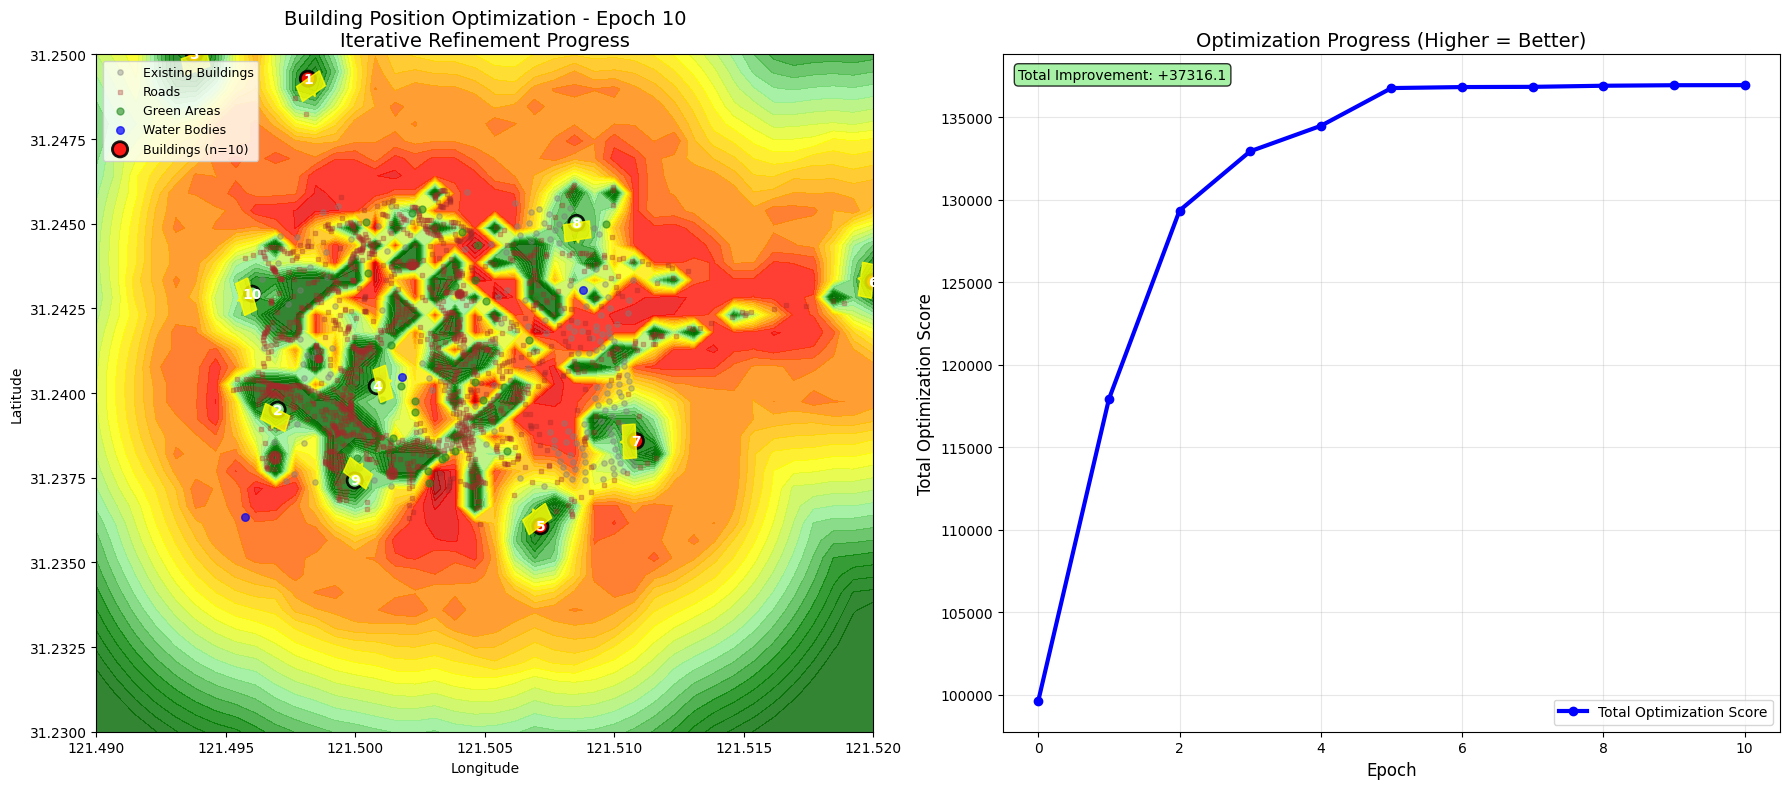

Creating final destination visualization...
✓ Final destination plot saved: /content/final_optimization_result.png


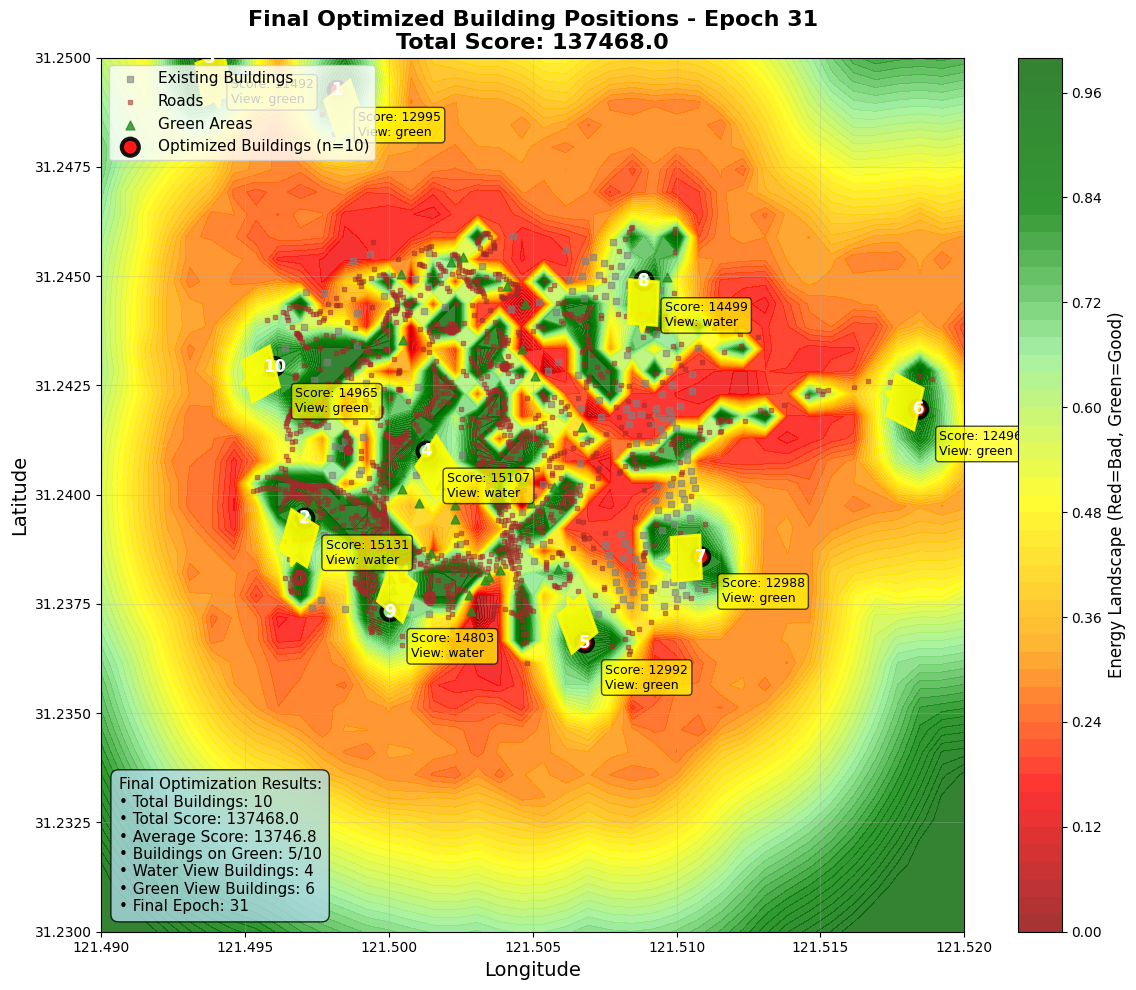

✅ Iterative optimization animation complete!
📊 Final Results:
   - Buildings optimized: 10
   - Total epochs: 32
   - Final total score: 137468.0
   - Building 1: (121.498201, 31.249249) Score: 12994.9
   - Building 2: (121.497075, 31.239464) Score: 15130.7
   - Building 3: (121.493772, 31.249999) Score: 11491.8
   - Building 4: (121.501289, 31.240995) Score: 15107.3
   - Building 5: (121.506796, 31.236610) Score: 12992.4
   - Building 6: (121.518412, 31.241953) Score: 12496.3
   - Building 7: (121.510837, 31.238579) Score: 12988.2
   - Building 8: (121.508864, 31.244893) Score: 14498.6
   - Building 9: (121.500036, 31.237324) Score: 14802.9
   - Building 10: (121.496020, 31.242931) Score: 14964.9


In [80]:
# RUN ITERATIVE OPTIMIZATION
if __name__ == "__main__":
    print("🚀 Starting ITERATIVE optimization with position refinement...")

    # Run optimization
    optimal_buildings = generate_optimal_locations_with_iterative_tracking(N_BUILDINGS_TO_PREDICT, max_epochs=200)

    # Save history
    history_df = save_optimization_history()

    # Save building results
    results_df = save_building_results()

    # Create iterative animation
    animation_obj = create_iterative_optimization_animation()

    # Create final destination plot
    final_plot = create_final_destination_plot()

    print("✅ Iterative optimization animation complete!")
    print(f"📊 Final Results:")
    print(f"   - Buildings optimized: {len(optimal_buildings)}")
    print(f"   - Total epochs: {len(epoch_data)}")
    print(f"   - Final total score: {sum(b['energy_score'] for b in optimal_buildings):.1f}")

    # Display final building positions
    for i, building in enumerate(optimal_buildings):
        print(f"   - Building {building['id']}: ({building['longitude']:.6f}, {building['latitude']:.6f}) "
              f"Score: {building['energy_score']:.1f}")